# Initial Models
## Notebook 4
###
####

### Imports and functions initialisation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# sklearn preprocessors and pipelines:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelBinarizer
from sklearn.compose import  make_column_transformer
from sklearn.pipeline import Pipeline


# sklearn models:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#sklearn metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, roc_curve, auc

# yellowbrick's visualisations
from yellowbrick.classifier import PrecisionRecallCurve, ClassPredictionError

# from custom_functions directory inside preprocessor.py you can reference Preprocessor_function:
from custom_functions.preprocessor import Preprocessor_function

Below I create the **multiclass_roc_auc_score_and_plot** to easily plot ROC Curves and calculate AUC scores for various multiclass models

In [2]:
def multiclass_roc_auc_score_and_plot(model, X_test, y_test, model_name = 'Logistic Regression', plot_font_size = 13):
    """
    Compute the ROC AUC score for each class and plot the ROC curves.
    ( this function can be applied only for models that use predict_proba() )

    :param model: The trained classification model.
    :param X_test: The test set features.
    :param y_test: The test set targets.
    :param model_name: The name of the model (default is 'Logistic Regression').
    :param plot_font_size: The font size for the plot (default is 13).
    :return: Dictionary of ROC AUC scores for each class.
    """
    y_prob = model.predict_proba(X_test)

    # Binarize the labels
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)

    # Get class names from your fitted model
    class_names = model.classes_

    n_classes = y_test_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Plot of a ROC curve for a specific class
    plt.figure()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i],
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=plot_font_size-1)
    plt.ylabel('True Positive Rate', fontsize=plot_font_size-1)
    plt.title('Receiver Operating Characteristic (ROC) of\n'+model_name+' Model (multi-class)',
              fontsize= plot_font_size)
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

### Importing and splitting the dataset
Below I import the data and follow the splitting strategy that was mentioned in Notebook 3:

In [3]:
data = pd.read_csv('data_clean/for_models_dataset.csv')

X = data.drop(columns=['Customer_ID', 'Credit_Score'])
y = data['Credit_Score']

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     random_state=42,
                     test_size=0.2,
                     stratify=y)

target_names = ['Good', 'Poor', 'Standard'] # needed for classification report

### Baseline Accuracy to be achieved by classifiers:

A way to calculate Baseline Accuracy is to use value_counts and max(). In other words, I calculate the relative frequencies of the unique values and then choose the maximum.

In [4]:
print(f"Baseline accuracy: {y_train.value_counts(normalize=True).max()*100:.2f}%\n\n")

baseline_accuracy = y_train.value_counts(normalize=True)
print(f"Baseline accuracy (class: Standard): {baseline_accuracy.iloc[0]*100:.2f}%")
print(f"Baseline accuracy (class: Poor): {baseline_accuracy.iloc[1]*100:.2f}%")
print(f"Baseline accuracy (class: Good): {baseline_accuracy.iloc[2]*100:.2f}%")

Baseline accuracy: 51.88%


Baseline accuracy (class: Standard): 51.88%
Baseline accuracy (class: Poor): 28.82%
Baseline accuracy (class: Good): 19.30%


The baseline accuracy should be the minimum accuracy achieved by the created classifier. In my case, I should achieve an accuracy equal or greater than **51.88%**.

#### Creating column transformers with the Preprocessor_function
Refer to **notebook 2** to understand why I include the features:
- **Credit_Utilization_Ratio**
- **Occupation**
- **Payment_Behaviour**
into the **excluded_features** list. 

In [5]:
excluded_features = ['Customer_ID', 'Credit_Utilization_Ratio', 'Occupation', 'Payment_Behaviour']
pr_oh = \
    Preprocessor_function(data = data,
                          target_variable = 'Credit_Score',
                          cat_encoder = 'oh',
                          excluded_features = excluded_features
                          ).fit(data)


pr_ord = \
    Preprocessor_function(data = data,
                          target_variable = 'Credit_Score',
                          cat_encoder = 'ord',
                          excluded_features = excluded_features
                          ).fit(data)

pr_oh

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['Age', 'Annual_Income', 'Outstanding_Debt',
                                  'Total_EMI_per_month', 'Delay_from_due_date',
                                  'Num_of_Delayed_Payment']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['Credit_Mix', 'Payment_of_Min_Amount'])])

### Initial Models
Below I create a pipeline with a simple Logistic Regression Classifier:

              precision    recall  f1-score   support

        Good       0.50      0.51      0.51       483
        Poor       0.54      0.35      0.42       720
    Standard       0.59      0.70      0.64      1297

    accuracy                           0.56      2500
   macro avg       0.54      0.52      0.52      2500
weighted avg       0.56      0.56      0.55      2500


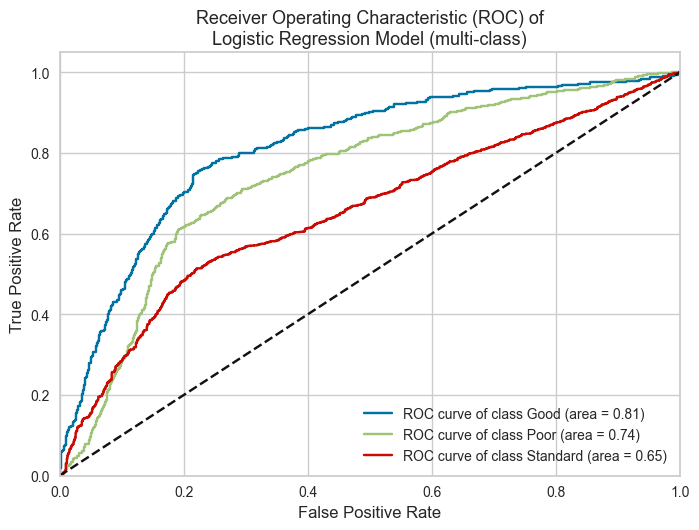

In [6]:
model_lr = \
Pipeline([
    ('preprocessor',pr_oh),
    ('estimator', LogisticRegression(multi_class='multinomial',random_state=42))
])

model_lr.fit(X_train, y_train)

#score_acc = model_lr.score(X_test, y_test)
print(classification_report(y_test, model_lr.predict(X_test),
                            target_names=target_names))

auc_scores = multiclass_roc_auc_score_and_plot(model_lr, X_test, y_test)

Below I use the GridSearchCV on Logistic Regression Pipeline:

              precision    recall  f1-score   support

        Good       0.50      0.51      0.51       483
        Poor       0.54      0.35      0.42       720
    Standard       0.59      0.70      0.64      1297

    accuracy                           0.56      2500
   macro avg       0.54      0.52      0.52      2500
weighted avg       0.56      0.56      0.55      2500


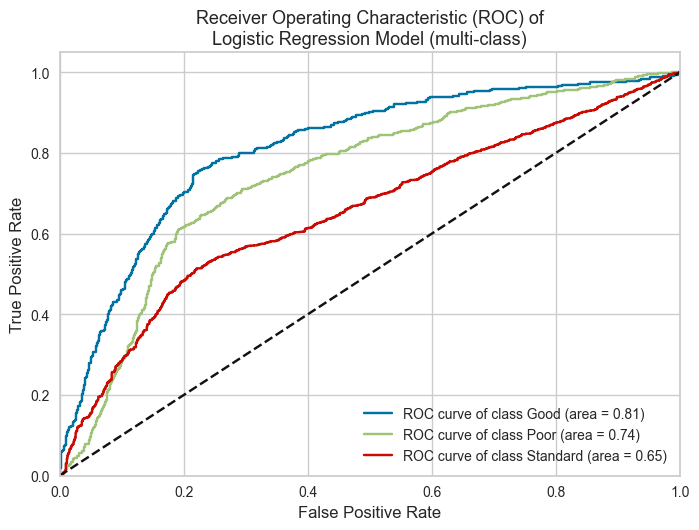

In [7]:
lr_params = {'estimator__C':[0.1,1,10,100,150,200,250,300,500,1000],
             'estimator__max_iter':[300, 1000, 10000]
             }

grid_lr = \
    GridSearchCV(estimator=model_lr,
                 param_grid= lr_params,
                 scoring='f1_weighted'
                 #multi_class = 'ovo'
                 ).fit(X_train, y_train)

print(classification_report(y_test,
                            grid_lr.best_estimator_.predict(X_test),
                            target_names=target_names)
      )

auc_scores = multiclass_roc_auc_score_and_plot(grid_lr.best_estimator_,
                                               X_test, y_test,
                                               model_name='Logistic Regression')

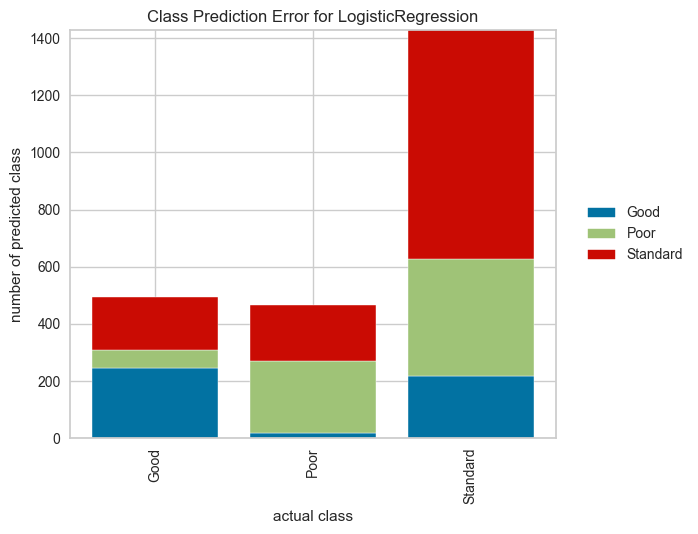

<Axes: title={'center': 'Class Prediction Error for LogisticRegression'}, xlabel='actual class', ylabel='number of predicted class'>

In [8]:
# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(grid_lr.best_estimator_,
                                  classes = grid_lr.best_estimator_.classes_)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

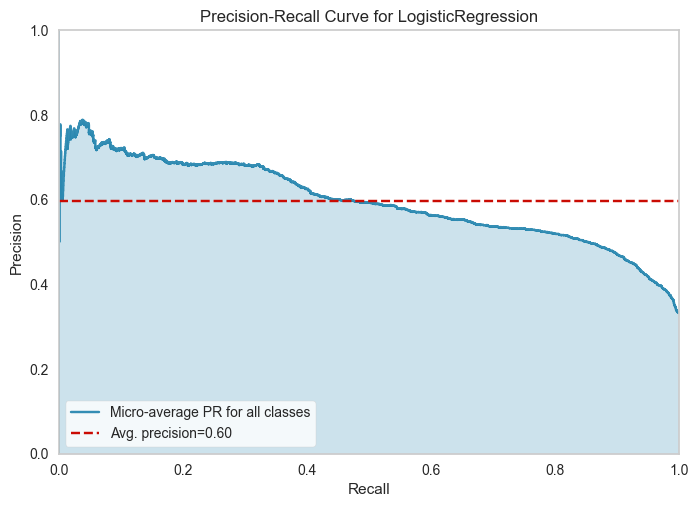

In [9]:
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(
    grid_lr.best_estimator_,
    per_class=False, micro=True,
    cmap="Set1"
)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show();

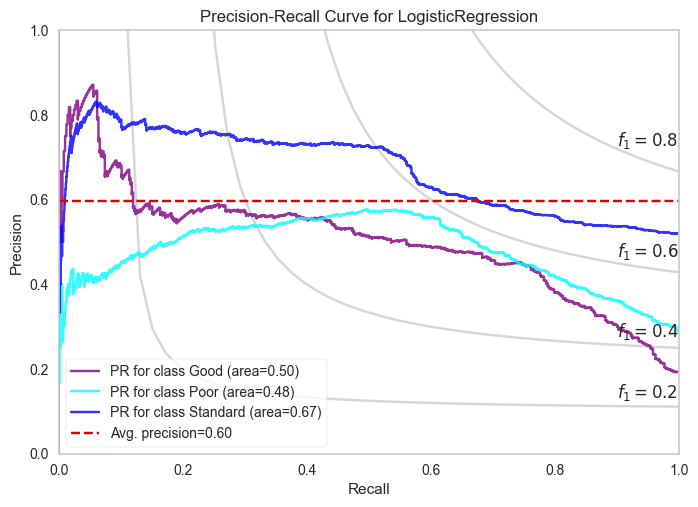

In [10]:
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(
    grid_lr.best_estimator_,
    per_class=True, micro=False,
    classes=grid_lr.best_estimator_.classes_,
    colors=["purple", "cyan", "blue"],
    iso_f1_curves=True,
    #cmap="Set1"
)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show();

Below I create a pipeline with a simple KNN Classifier:

              precision    recall  f1-score   support

        Good       0.50      0.51      0.50       483
        Poor       0.57      0.53      0.55       720
    Standard       0.63      0.66      0.65      1297

    accuracy                           0.59      2500
   macro avg       0.57      0.56      0.57      2500
weighted avg       0.59      0.59      0.59      2500


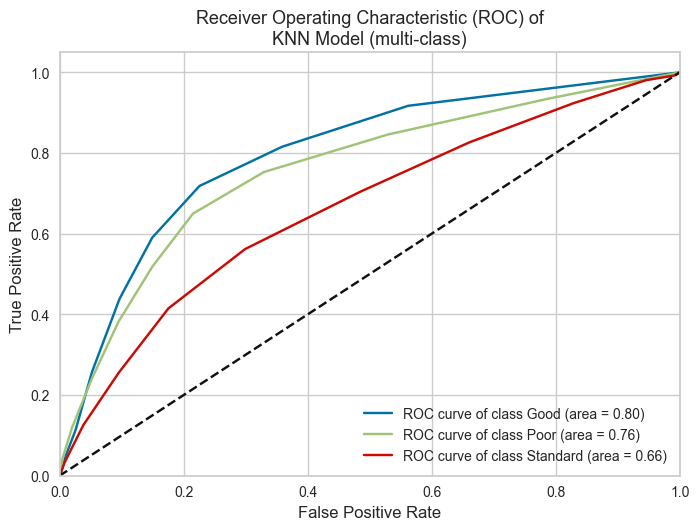

In [11]:
model_knn = \
    Pipeline([
        ('preprocessor',pr_oh),
        ('estimator', KNeighborsClassifier(n_neighbors=10))
    ])

model_knn.fit(X_train, y_train)

#score_acc = model_lr.score(X_test, y_test)
print(classification_report(y_test, model_knn.predict(X_test),
                            target_names=target_names))

auc_scores = multiclass_roc_auc_score_and_plot(model_knn, X_test, y_test, model_name='KNN')

Below I create a pipeline with a simple Decision Tree Classifier:

              precision    recall  f1-score   support

        Good       0.38      0.40      0.39       483
        Poor       0.46      0.45      0.45       720
    Standard       0.58      0.57      0.57      1297

    accuracy                           0.50      2500
   macro avg       0.47      0.47      0.47      2500
weighted avg       0.50      0.50      0.50      2500


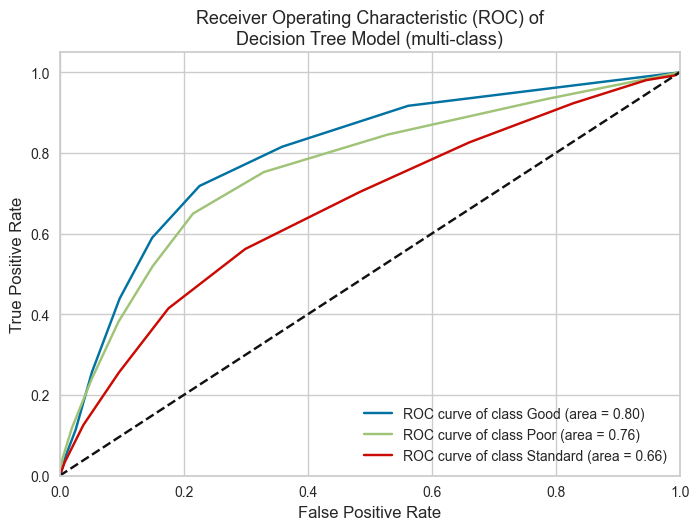

In [12]:
model_dtr = \
    Pipeline([
        ('preprocessor',pr_ord),
        ('estimator', DecisionTreeClassifier(random_state=42))
    ])

model_dtr.fit(X_train, y_train)

#score_acc = model_lr.score(X_test, y_test)
print(classification_report(y_test, model_dtr.predict(X_test),
                            target_names=target_names))

auc_scores = multiclass_roc_auc_score_and_plot(model_knn, X_test, y_test, model_name='Decision Tree')